In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import momlevel as ml

# from cmip_basins.basins import generate_basin_codes
# import cmip_basins.gfdl as gfdl
# import cmip_basins.cmip6 as cmip6
# import regionmask

import xesmf as xe

import cartopy.crs as ccrs
import cmocean
import wocemaps as wm

from dask.distributed import Client
from dask.distributed import LocalCluster

import warnings

In [2]:
# using for regridding 

cm4_static = xr.open_dataset('/backup/tuq41374/model_output/sofia/antwater/gfdl-cm4/static/static_files/ocean_monthly_z.static.nc',
                         use_cftime = True)

cm4_weights = cm4_static.areacello * cm4_static.wet


In [3]:
cm4_historical_sst_mon = xr.open_mfdataset('/backup/tuq41374/model_output/cmip6/historical/gfdl_cm4/ocean/monthly/tos/*.nc',
                                      use_cftime = True).tos.assign_coords({'lon':cm4_static.geolon,
                                                                            'lat':cm4_static.geolat})

In [4]:
mb_all_gt = pd.read_csv('/home/pachamama/imbie/imbie_all_2021_Gt.csv')
mb_all_mm = pd.read_csv('/home/pachamama/imbie/imbie_all_2021_mm.csv')

mb_ant_gt = pd.read_csv('/home/pachamama/imbie/imbie_antarctica_2021_Gt.csv')
mb_ant_mm = pd.read_csv('/home/pachamama/imbie/imbie_antarctica_2021_mm.csv')

mb_gr_gt = pd.read_csv('/home/pachamama/imbie/imbie_greenland_2021_Gt.csv')
mb_gr_mm = pd.read_csv('/home/pachamama/imbie/imbie_greenland_2021_mm.csv')

sea_lev = xr.open_mfdataset('/home/pachamama/sat_SL/*.nc').sel(time=slice('1993','2020'))

In [5]:
sea_lev

<xarray.Dataset>
Dimensions:           (time: 313, nv: 2, latitude: 720, longitude: 1440)
Coordinates:
  * time              (time) datetime64[ns] 1993-01-15 1993-02-15 ... 2020-12-15
  * latitude          (latitude) float32 -89.88 -89.62 -89.38 ... 89.62 89.88
  * longitude         (longitude) float32 0.125 0.375 0.625 ... 359.6 359.9
  * nv                (nv) int32 0 1
Data variables:
    crs               (time) int32 -2147483647 -2147483647 ... -2147483647
    climatology_bnds  (time, nv) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    lat_bnds          (time, latitude, nv) float32 dask.array<chunksize=(1, 720, 2), meta=np.ndarray>
    lon_bnds          (time, longitude, nv) float32 dask.array<chunksize=(1, 1440, 2), meta=np.ndarray>
    sla               (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    eke               (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes: (12/43)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Monthly Mean of Sea Level Anomalies refe...
    contact:                         http://climate.copernicus.eu/c3s-user-se...
    creator_email:                   http://climate.copernicus.eu/c3s-user-se...
    ...                              ...
    summary:                         Delayed Time Level-4 monthly means of Se...
    time_coverage_duration:          P1M
    time_coverage_end:               1993-01-31T00:00:00Z
    time_coverage_resolution:        P1M
    time_coverage_start:             1993-01-01T00:00:00Z
    title:                           DT merged two-satellite Global Ocean L4 ...

In [6]:
regridder = xe.Regridder(sea_lev, cm4_historical_sst_mon, "bilinear")

In [7]:
sea_lev_regridded = regridder(sea_lev)

In [8]:

# Function to convert decimal date to YYYY-MM-DD
def decimal_to_date(decimal_date):
    
    import datetime
    
    year = int(decimal_date)  # Extract the year
    fraction = decimal_date - year  # Get the fractional part
    # Calculate the date by adding the fraction as days
    start_of_year = datetime.date(year, 1, 1)
    days_in_year = (datetime.date(year + 1, 1, 1) - start_of_year).days
    converted_date = start_of_year + datetime.timedelta(days=fraction * days_in_year)
    return converted_date

In [9]:
# converting decimal times to yyyy-mm-dd

mb_all_gt['time'] = mb_all_gt['Year'].apply(decimal_to_date)
mb_all_mm['time'] = mb_all_mm['Year'].apply(decimal_to_date)

mb_ant_gt['time'] = mb_ant_gt['Year'].apply(decimal_to_date)
mb_ant_mm['time'] = mb_ant_mm['Year'].apply(decimal_to_date)

mb_gr_gt['time'] = mb_gr_gt['Year'].apply(decimal_to_date)
mb_gr_mm['time'] = mb_gr_mm['Year'].apply(decimal_to_date)

In [10]:
def annual_mean_gt(df):

    df['time'] = pd.to_datetime(df['time'])

    df['year'] = df['time'].dt.year

    # Compute the annual average
    df_ann_mb = df.groupby('year')['Mass balance (Gt/yr)'].mean().reset_index()

    df_ann_mb_unc = df.groupby('year')['Mass balance uncertainty (Gt/yr)'].mean().reset_index()

    df_ann_cumu_mb = df.groupby('year')['Cumulative mass balance (Gt)'].mean().reset_index()

    df_ann_cumu_mb_unc = df.groupby('year')['Cumulative mass balance uncertainty (Gt)'].mean().reset_index()

    # Rename columns for clarity
    df_ann_mb.columns = ['year', 'annual_avg_mb']
    df_ann_mb_unc.columns = ['year', 'annual_avg_mb_unc']
    df_ann_cumu_mb.columns = ['year', 'annual_avg_cumu_mb']
    df_ann_cumu_mb_unc.columns = ['year', 'annual_avg_cumu_mb_unc']

    df_ann = pd.concat(
        [
            df_ann_mb.set_index('year'), 
            df_ann_mb_unc.set_index('year'), 
            df_ann_cumu_mb.set_index('year'), 
            df_ann_cumu_mb_unc.set_index('year')
        ], axis=1
    )

    ds_out = df_ann.to_xarray()

    return ds_out

def annual_mean_mm(df):

    df['time'] = pd.to_datetime(df['time'])

    df['year'] = df['time'].dt.year

       # Compute the annual average
    df_ann_mb = df.groupby('year')['Mass balance (mm/yr)'].mean().reset_index()

    df_ann_mb_unc = df.groupby('year')['Mass balance uncertainty (mm/yr)'].mean().reset_index()

    df_ann_cumu_mb = df.groupby('year')['Cumulative mass balance (mm)'].mean().reset_index()

    df_ann_cumu_mb_unc = df.groupby('year')['Cumulative mass balance uncertainty (mm)'].mean().reset_index()

    # Rename columns for clarity
    df_ann_mb.columns = ['year', 'annual_avg_mb']
    df_ann_mb_unc.columns = ['year', 'annual_avg_mb_unc']
    df_ann_cumu_mb.columns = ['year', 'annual_avg_cumu_mb']
    df_ann_cumu_mb_unc.columns = ['year', 'annual_avg_cumu_mb_unc']

    df_ann = pd.concat(
        [
            df_ann_mb.set_index('year'), 
            df_ann_mb_unc.set_index('year'), 
            df_ann_cumu_mb.set_index('year'), 
            df_ann_cumu_mb_unc.set_index('year')
        ], axis=1
    )
    
    ds_out = df_ann.to_xarray()

    return ds_out


In [11]:
# annual average for xrarray datasets

def compute_annual_average(ds, time_dim='time'):
    """
    Compute the annual average of an xarray Dataset or DataArray.

    Parameters:
    - ds (xarray.Dataset or xarray.DataArray): Input data with a time dimension.
    - time_dim (str): Name of the time dimension in the dataset. Default is 'time'.

    Returns:
    - xarray.Dataset or xarray.DataArray: Annual averages grouped by year.
    """
    if time_dim not in ds.dims:
        raise ValueError(f"'{time_dim}' dimension not found in the input data.")
    
    # Ensure the time dimension is a datetime format
    ds[time_dim] = xr.DataArray(pd.to_datetime(ds[time_dim].values), dims=time_dim)
    
    # Group by year and compute the mean
    annual_avg = ds.groupby(f"{time_dim}.year").mean(time_dim)
    
    # Rename the 'year' coordinate for clarity (optional)
    annual_avg = annual_avg.rename({'year': f"{time_dim}_year"})
    
    return annual_avg

In [12]:
# annual mean
mb_all_gt_ann = annual_mean_gt(mb_all_gt).sel(year=slice(1993,2021))
mb_all_mm_ann = annual_mean_mm(mb_all_mm).sel(year=slice(1993,2021))

mb_ant_gt_ann = annual_mean_gt(mb_ant_gt).sel(year=slice(1993,2021))
mb_ant_mm_ann = annual_mean_mm(mb_ant_mm).sel(year=slice(1993,2021))

mb_gr_gt_ann = annual_mean_gt(mb_gr_gt).sel(year=slice(1993,2021))
mb_gr_mm_ann = annual_mean_mm(mb_gr_mm).sel(year=slice(1993,2021))


sea_lev_ann = compute_annual_average(sea_lev_regridded).assign_coords({'geolon':cm4_static.geolon,
                                                                            'geolat':cm4_static.geolat})

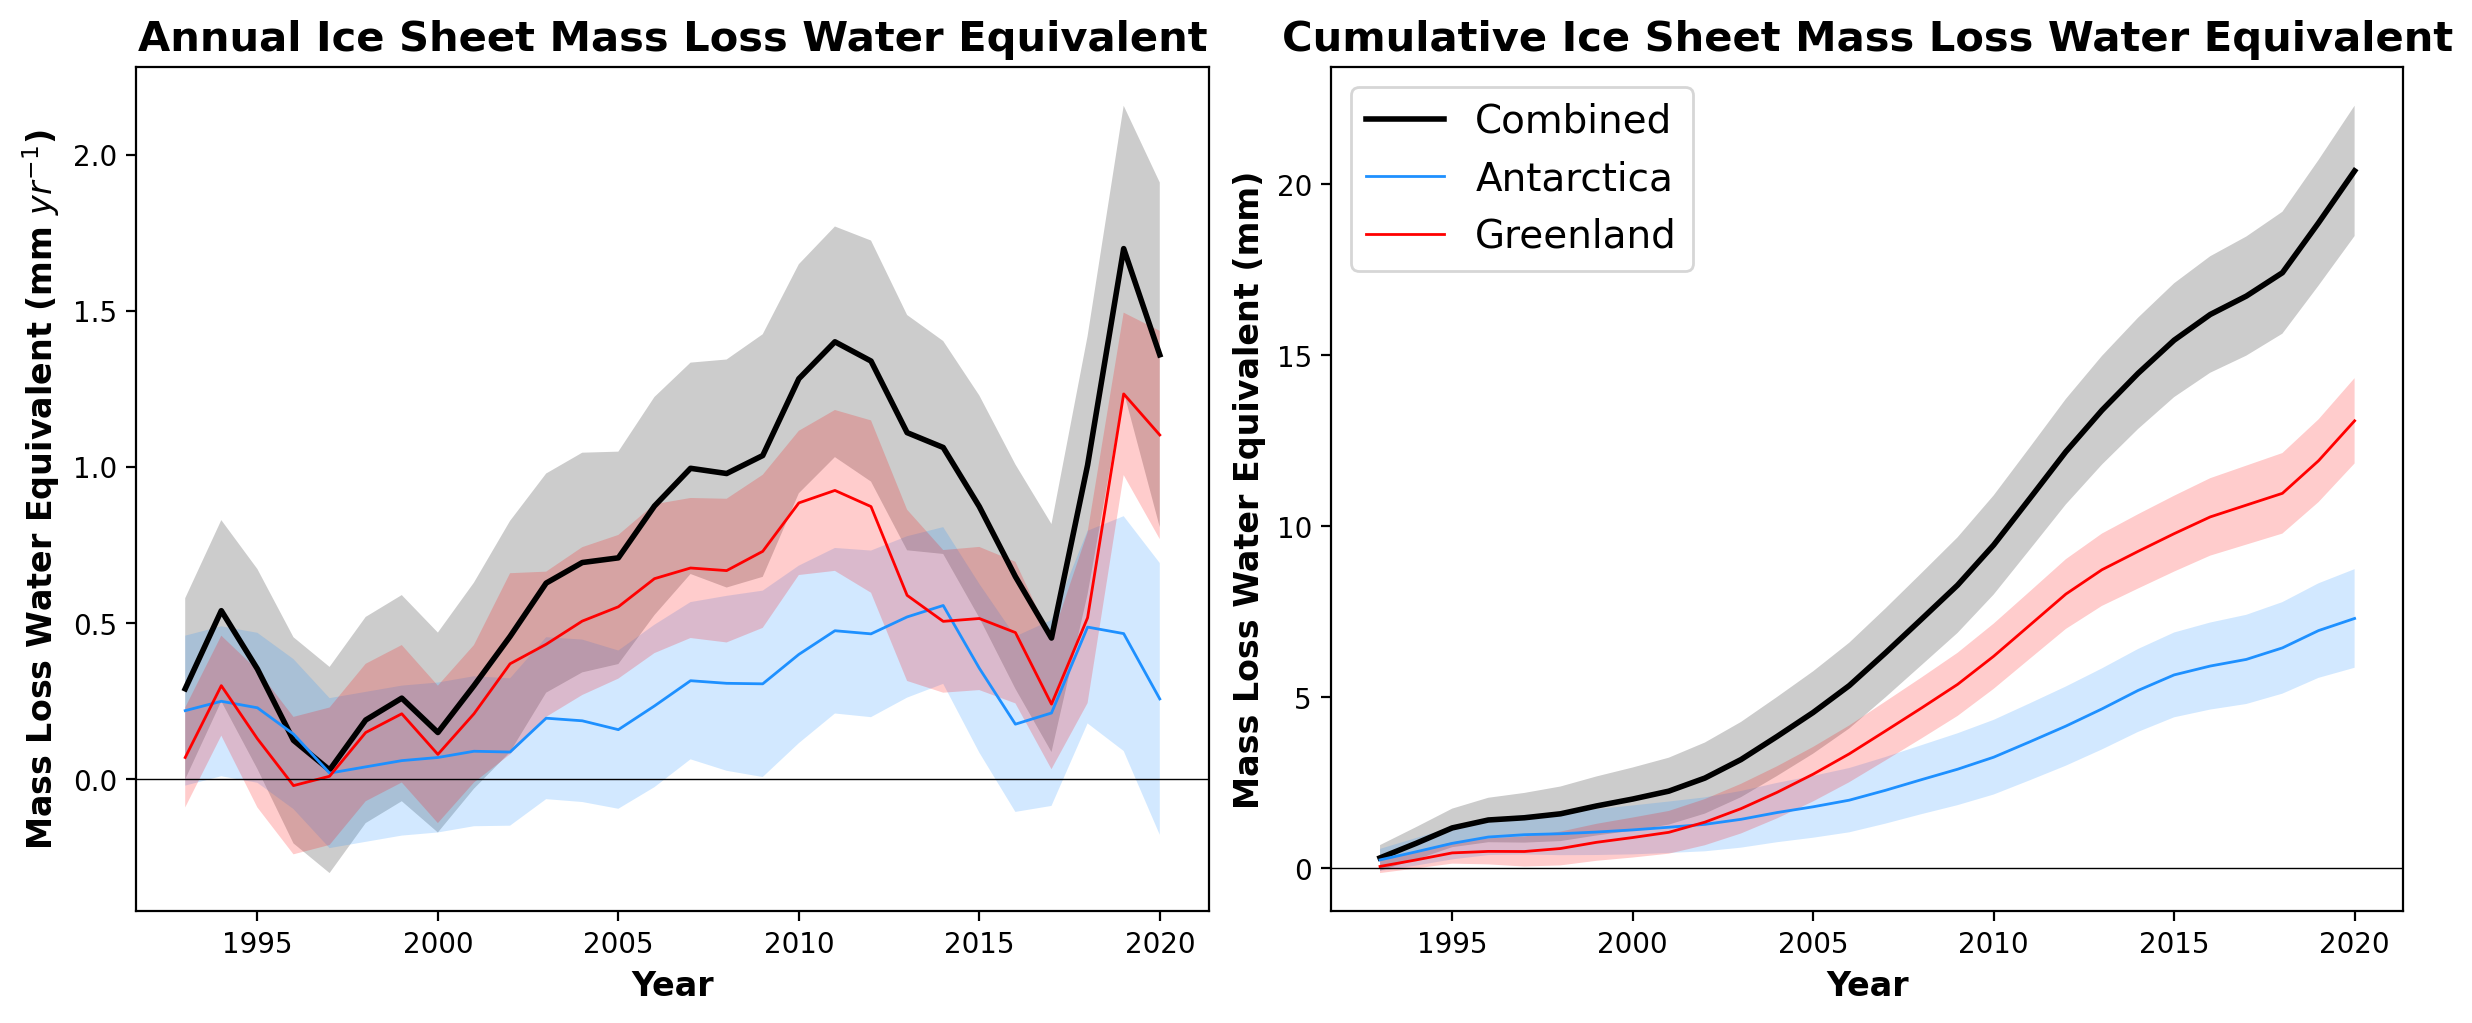

In [13]:
fig, ax = plt.subplots(figsize=(12,5),
                      ncols=2,
                      layout='constrained')

# per year
# all
mb_all_mm_ann.annual_avg_mb.plot(label='Combined', color='k', lw=2, ax=ax[0])

ax[0].fill_between(mb_all_mm_ann.year, 
                (mb_all_mm_ann.annual_avg_mb + mb_all_mm_ann.annual_avg_mb_unc), 
                (mb_all_mm_ann.annual_avg_mb - mb_all_mm_ann.annual_avg_mb_unc),
                color='black',
                edgecolor='none',
                alpha=0.2)


# AIS 
mb_ant_mm_ann.annual_avg_mb.plot(label='Antarctica', color='dodgerblue', lw=1, ax=ax[0])

ax[0].fill_between(mb_ant_mm_ann.year, 
                (mb_ant_mm_ann.annual_avg_mb + mb_ant_mm_ann.annual_avg_mb_unc), 
                (mb_ant_mm_ann.annual_avg_mb - mb_ant_mm_ann.annual_avg_mb_unc),
                color='dodgerblue',
                edgecolor='none',
                alpha=0.2)


# GrIS 
mb_gr_mm_ann.annual_avg_mb.plot(label='Greenland', color='red', lw=1, ax=ax[0])

ax[0].fill_between(mb_gr_mm_ann.year, 
                (mb_gr_mm_ann.annual_avg_mb + mb_gr_mm_ann.annual_avg_mb_unc), 
                (mb_gr_mm_ann.annual_avg_mb - mb_gr_mm_ann.annual_avg_mb_unc),
                color='red',
                edgecolor='none',
                alpha=0.2)

ax[0].set_title('Annual Ice Sheet Mass Loss Water Equivalent', fontsize=15, weight='bold')
ax[0].set_xlabel('Year', fontsize=12, weight='bold')
ax[0].set_ylabel(r'Mass Loss Water Equivalent (mm $yr^{-1}$)', fontsize=12, weight='bold')


ax[0].axhline(color='k', lw=.5)

#cumulative

mb_all_mm_ann.annual_avg_cumu_mb.plot(label='Combined', color='k', lw=2, ax=ax[1])

ax[1].fill_between(mb_all_mm_ann.year, 
                (mb_all_mm_ann.annual_avg_cumu_mb + mb_all_mm_ann.annual_avg_cumu_mb_unc), 
                (mb_all_mm_ann.annual_avg_cumu_mb - mb_all_mm_ann.annual_avg_cumu_mb_unc),
                color='black',
                edgecolor='none',
                alpha=0.2)


# AIS 
mb_ant_mm_ann.annual_avg_cumu_mb.plot(label='Antarctica', color='dodgerblue', lw=1, ax=ax[1])

ax[1].fill_between(mb_ant_mm_ann.year, 
                (mb_ant_mm_ann.annual_avg_cumu_mb + mb_ant_mm_ann.annual_avg_cumu_mb_unc), 
                (mb_ant_mm_ann.annual_avg_cumu_mb - mb_ant_mm_ann.annual_avg_cumu_mb_unc),
                color='dodgerblue',
                edgecolor='none',
                alpha=0.2)


# GrIS 
mb_gr_mm_ann.annual_avg_cumu_mb.plot(label='Greenland', color='red', lw=1, ax=ax[1])

ax[1].fill_between(mb_gr_mm_ann.year, 
                (mb_gr_mm_ann.annual_avg_cumu_mb + mb_gr_mm_ann.annual_avg_cumu_mb_unc), 
                (mb_gr_mm_ann.annual_avg_cumu_mb - mb_gr_mm_ann.annual_avg_cumu_mb_unc),
                color='red',
                edgecolor='none',
                alpha=0.2)

ax[1].set_title('Cumulative Ice Sheet Mass Loss Water Equivalent', fontsize=15, weight='bold')
ax[1].set_xlabel('Year', fontsize=12, weight='bold')
ax[1].set_ylabel(r'Mass Loss Water Equivalent (mm)', fontsize=12, weight='bold')
ax[1].legend(fontsize=14)

ax[1].axhline(color='k', lw=.5)

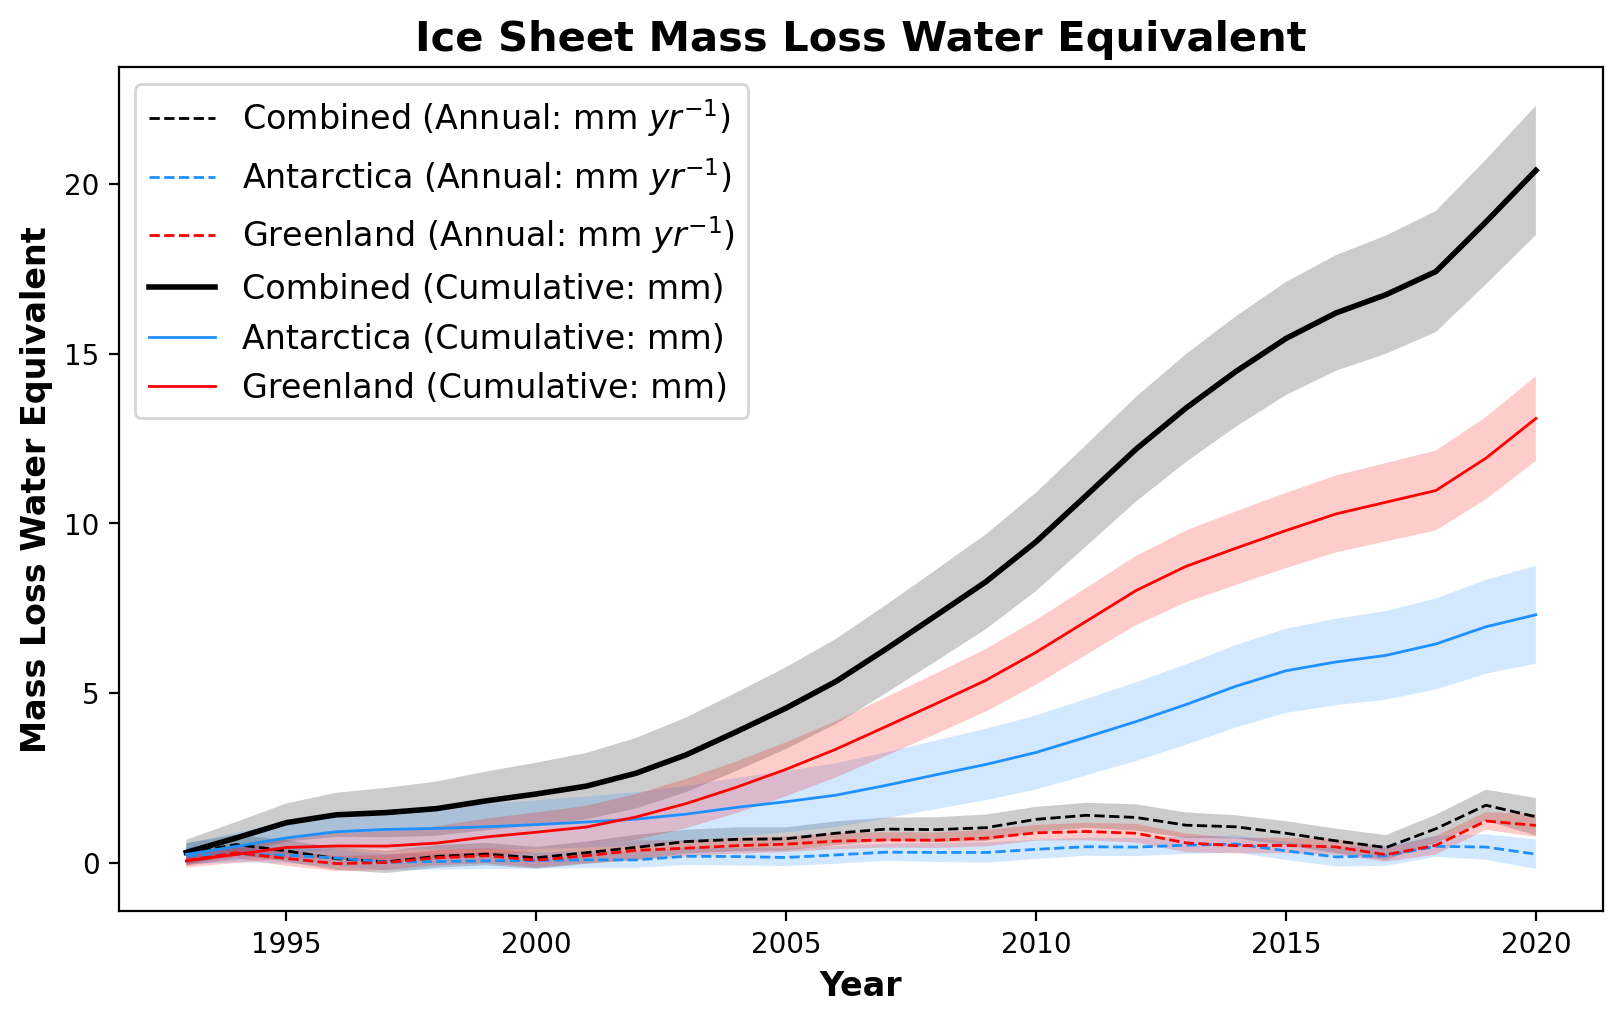

In [42]:
fig, ax = plt.subplots(figsize=(8,5),
                      layout='constrained')

# per year
# all
mb_all_mm_ann.annual_avg_mb.plot(label='Combined (Annual: mm $yr^{-1}$)', color='k', ls='--', lw=1)

ax.fill_between(mb_all_mm_ann.year, 
                (mb_all_mm_ann.annual_avg_mb + mb_all_mm_ann.annual_avg_mb_unc), 
                (mb_all_mm_ann.annual_avg_mb - mb_all_mm_ann.annual_avg_mb_unc),
                color='black',
                edgecolor='none',
                alpha=0.2)


# AIS 
mb_ant_mm_ann.annual_avg_mb.plot(label='Antarctica (Annual: mm $yr^{-1}$)', color='dodgerblue', ls='--', lw=1)

ax.fill_between(mb_ant_mm_ann.year, 
                (mb_ant_mm_ann.annual_avg_mb + mb_ant_mm_ann.annual_avg_mb_unc), 
                (mb_ant_mm_ann.annual_avg_mb - mb_ant_mm_ann.annual_avg_mb_unc),
                color='dodgerblue',
                edgecolor='none',
                alpha=0.2)


# GrIS 
mb_gr_mm_ann.annual_avg_mb.plot(label='Greenland (Annual: mm $yr^{-1}$)', color='red', ls='--', lw=1)

ax.fill_between(mb_gr_mm_ann.year, 
                (mb_gr_mm_ann.annual_avg_mb + mb_gr_mm_ann.annual_avg_mb_unc), 
                (mb_gr_mm_ann.annual_avg_mb - mb_gr_mm_ann.annual_avg_mb_unc),
                color='red',
                edgecolor='none',
                alpha=0.2)



#cumulative

mb_all_mm_ann.annual_avg_cumu_mb.plot(label='Combined (Cumulative: mm)', color='k', lw=2)

ax.fill_between(mb_all_mm_ann.year, 
                (mb_all_mm_ann.annual_avg_cumu_mb + mb_all_mm_ann.annual_avg_cumu_mb_unc), 
                (mb_all_mm_ann.annual_avg_cumu_mb - mb_all_mm_ann.annual_avg_cumu_mb_unc),
                color='black',
                edgecolor='none',
                alpha=0.2)


# AIS 
mb_ant_mm_ann.annual_avg_cumu_mb.plot(label='Antarctica (Cumulative: mm)', color='dodgerblue', lw=1)

ax.fill_between(mb_ant_mm_ann.year, 
                (mb_ant_mm_ann.annual_avg_cumu_mb + mb_ant_mm_ann.annual_avg_cumu_mb_unc), 
                (mb_ant_mm_ann.annual_avg_cumu_mb - mb_ant_mm_ann.annual_avg_cumu_mb_unc),
                color='dodgerblue',
                edgecolor='none',
                alpha=0.2)


# GrIS 
mb_gr_mm_ann.annual_avg_cumu_mb.plot(label='Greenland (Cumulative: mm)', color='red', lw=1)

ax.fill_between(mb_gr_mm_ann.year, 
                (mb_gr_mm_ann.annual_avg_cumu_mb + mb_gr_mm_ann.annual_avg_cumu_mb_unc), 
                (mb_gr_mm_ann.annual_avg_cumu_mb - mb_gr_mm_ann.annual_avg_cumu_mb_unc),
                color='red',
                edgecolor='none',
                alpha=0.2)

ax.set_title('Ice Sheet Mass Loss Water Equivalent', fontsize=15, weight='bold')
ax.set_xlabel('Year', fontsize=12, weight='bold')
ax.set_ylabel(r'Mass Loss Water Equivalent', fontsize=12, weight='bold')

ax.legend(fontsize=12)

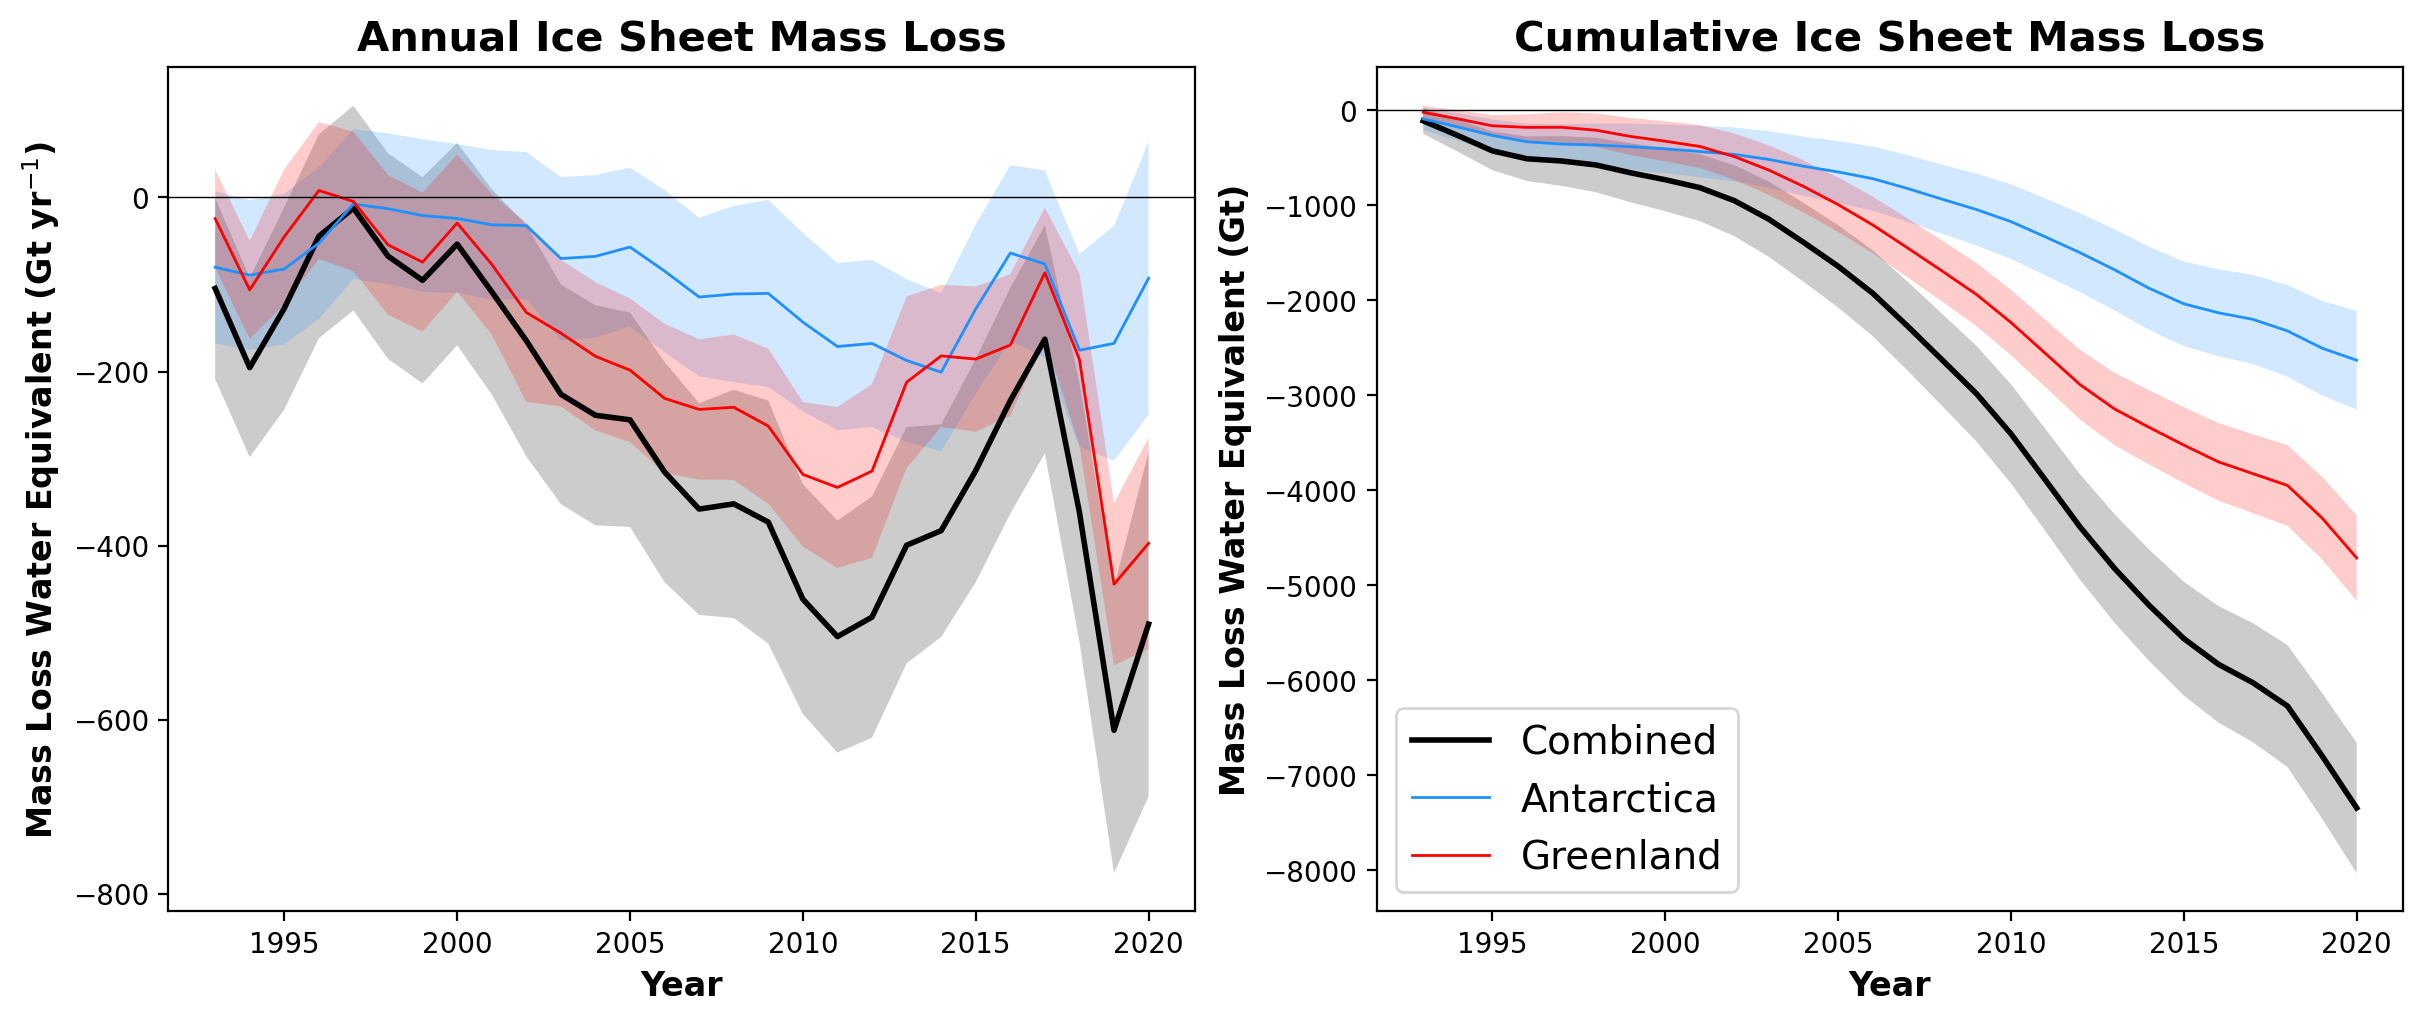

In [43]:
fig, ax = plt.subplots(figsize=(12,5),
                      ncols=2,
                      layout='constrained')

# per year
# all
mb_all_gt_ann.annual_avg_mb.plot(label='Combined', color='k', lw=2, ax=ax[0])

ax[0].fill_between(mb_all_gt_ann.year, 
                (mb_all_gt_ann.annual_avg_mb + mb_all_gt_ann.annual_avg_mb_unc), 
                (mb_all_gt_ann.annual_avg_mb - mb_all_gt_ann.annual_avg_mb_unc),
                color='black',
                edgecolor='none',
                alpha=0.2)


# AIS 
mb_ant_gt_ann.annual_avg_mb.plot(label='Antarctica', color='dodgerblue', lw=1, ax=ax[0])

ax[0].fill_between(mb_ant_gt_ann.year, 
                (mb_ant_gt_ann.annual_avg_mb + mb_ant_gt_ann.annual_avg_mb_unc), 
                (mb_ant_gt_ann.annual_avg_mb - mb_ant_gt_ann.annual_avg_mb_unc),
                color='dodgerblue',
                edgecolor='none',
                alpha=0.2)


# GrIS 
mb_gr_gt_ann.annual_avg_mb.plot(label='Greenland', color='red', lw=1, ax=ax[0])

ax[0].fill_between(mb_gr_gt_ann.year, 
                (mb_gr_gt_ann.annual_avg_mb + mb_gr_gt_ann.annual_avg_mb_unc), 
                (mb_gr_gt_ann.annual_avg_mb - mb_gr_gt_ann.annual_avg_mb_unc),
                color='red',
                edgecolor='none',
                alpha=0.2)

ax[0].set_title('Annual Ice Sheet Mass Loss', fontsize=15, weight='bold')
ax[0].set_xlabel('Year', fontsize=12, weight='bold')
ax[0].set_ylabel(r'Mass Loss Water Equivalent (Gt yr$^{-1}$)', fontsize=12, weight='bold')

ax[0].axhline(color='k', lw=.5)

#cumulative

mb_all_gt_ann.annual_avg_cumu_mb.plot(label='Combined', color='k', lw=2, ax=ax[1])

ax[1].fill_between(mb_all_gt_ann.year, 
                (mb_all_gt_ann.annual_avg_cumu_mb + mb_all_gt_ann.annual_avg_cumu_mb_unc), 
                (mb_all_gt_ann.annual_avg_cumu_mb - mb_all_gt_ann.annual_avg_cumu_mb_unc),
                color='black',
                edgecolor='none',
                alpha=0.2)


# AIS 
mb_ant_gt_ann.annual_avg_cumu_mb.plot(label='Antarctica', color='dodgerblue', lw=1, ax=ax[1])

ax[1].fill_between(mb_ant_gt_ann.year, 
                (mb_ant_gt_ann.annual_avg_cumu_mb + mb_ant_gt_ann.annual_avg_cumu_mb_unc), 
                (mb_ant_gt_ann.annual_avg_cumu_mb - mb_ant_gt_ann.annual_avg_cumu_mb_unc),
                color='dodgerblue',
                edgecolor='none',
                alpha=0.2)


# GrIS 
mb_gr_gt_ann.annual_avg_cumu_mb.plot(label='Greenland', color='red', lw=1, ax=ax[1])

ax[1].fill_between(mb_gr_gt_ann.year, 
                (mb_gr_gt_ann.annual_avg_cumu_mb + mb_gr_gt_ann.annual_avg_cumu_mb_unc), 
                (mb_gr_gt_ann.annual_avg_cumu_mb - mb_gr_gt_ann.annual_avg_cumu_mb_unc),
                color='red',
                edgecolor='none',
                alpha=0.2)

ax[1].set_title('Cumulative Ice Sheet Mass Loss', fontsize=15, weight='bold')
ax[1].set_xlabel('Year', fontsize=12, weight='bold')
ax[1].set_ylabel(r'Mass Loss Water Equivalent (Gt)', fontsize=12, weight='bold')
ax[1].legend(fontsize=14)

ax[1].axhline(color='k', lw=.5)

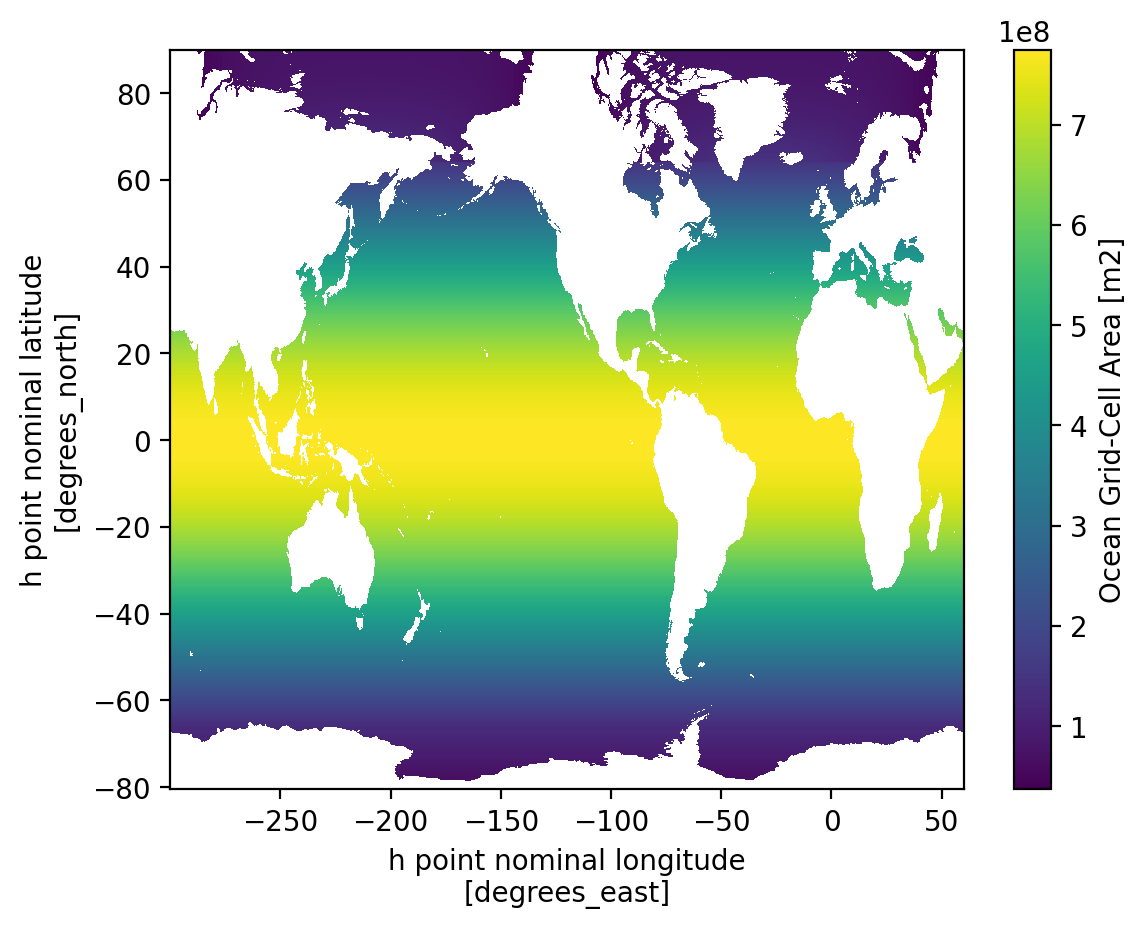

In [18]:
cm4_static.areacello.where(cm4_static.wet ==1).plot()

In [102]:
sea_lev_ann.sla.sel(time_year=slice(2010, 2020)).mean('time_year').mean(['xh','yh']).values

/home/tu.temple.edu/tuk08919/miniconda3/envs/occ_complex_2/lib/python3.9/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 142.53 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


array(0.0600493)

/home/tu.temple.edu/tuk08919/miniconda3/envs/occ_complex_2/lib/python3.9/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 142.53 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Text(0.5, 1.0, 'Sea Level Anomaly\n2010-2020 vs. 1993-2012 Baseline')

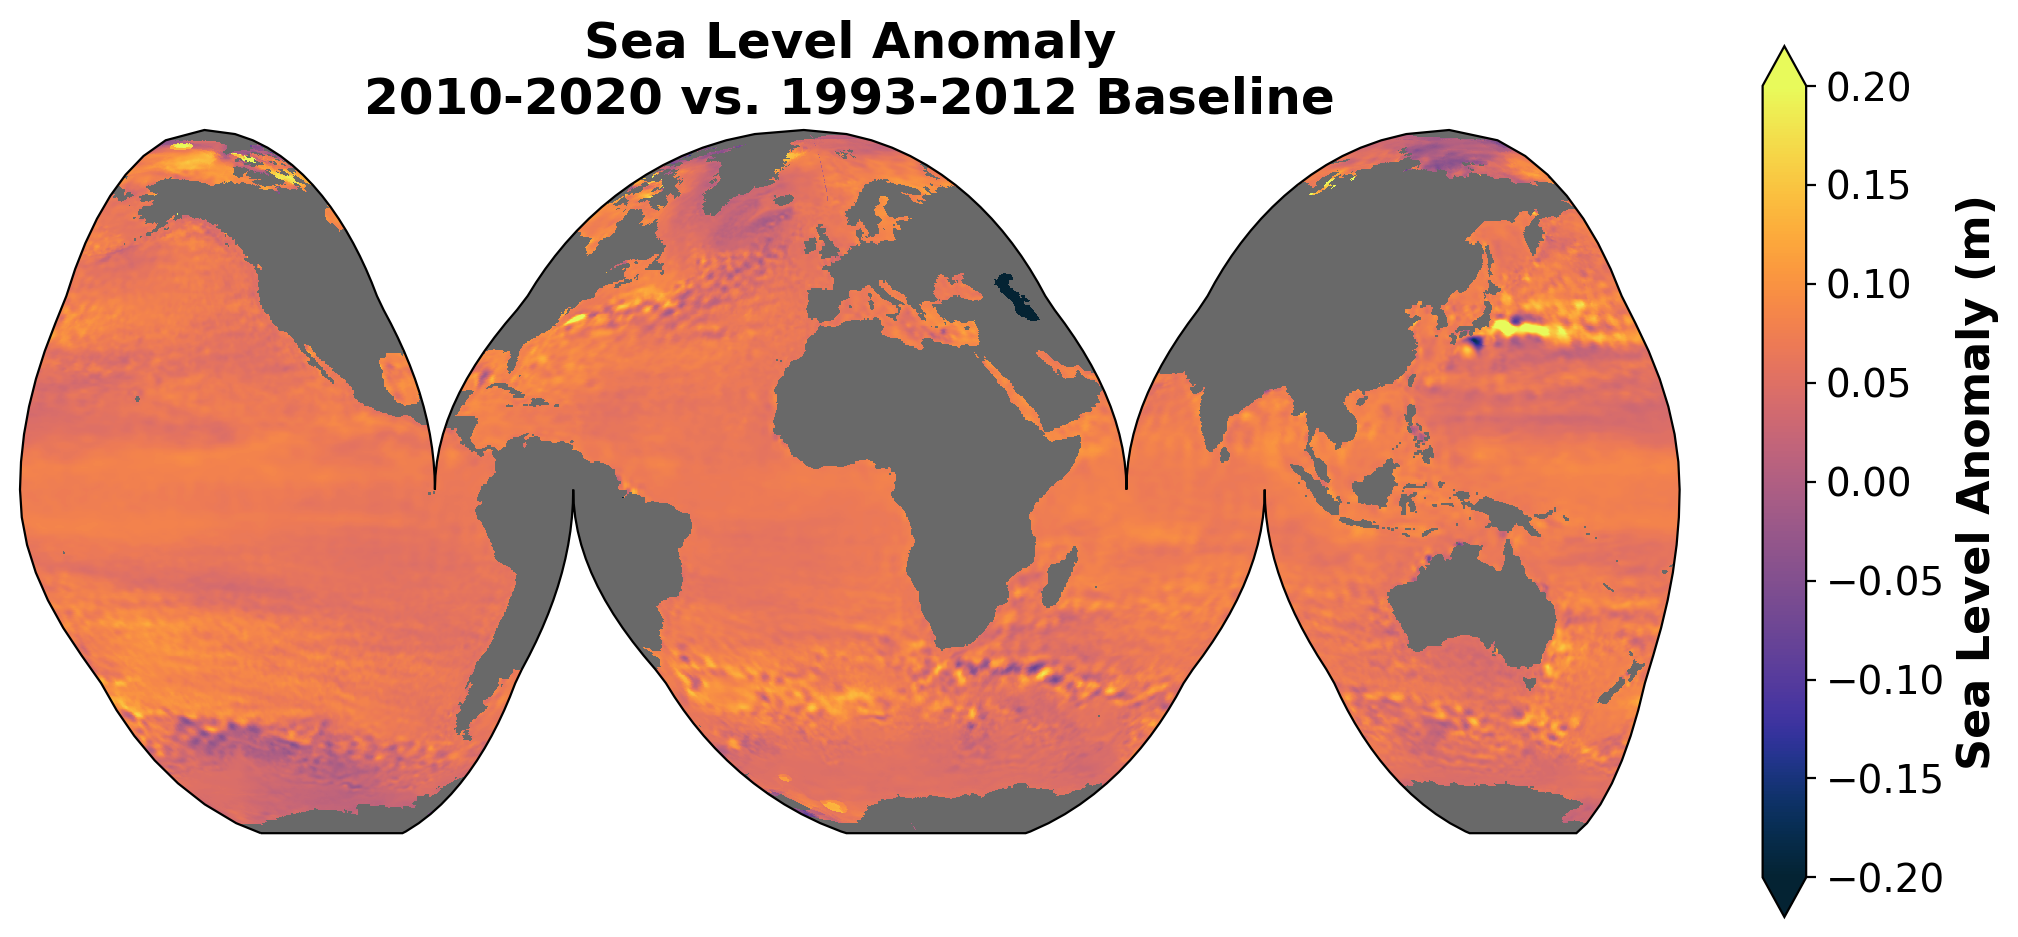

In [104]:
fig, ax = plt.subplots(figsize=(10,8),
                       layout='constrained',
                       subplot_kw={'projection':ccrs.InterruptedGoodeHomolosine(emphasis='ocean'), 'facecolor':'dimgrey'})

p = sea_lev_ann.sla.sel(time_year=slice(2010, 2020)).mean('time_year').plot(x='lon', y='lat',
                                                                        cmap=cmocean.cm.thermal, 
                                                                        transform=ccrs.PlateCarree(),
                                                                        vmin=-.2, vmax=.2,
                                                                         add_colorbar=False
                                                                        )

cbar = plt.colorbar(p, ticks=np.linspace(-.20,.20,9), shrink=0.55, extend='both')
cbar.set_label(label='Sea Level Anomaly (m)', fontsize=16, weight='bold')
cbar.ax.tick_params(labelsize=14)

plt.title('Sea Level Anomaly\n2010-2020 vs. 1993-2012 Baseline', fontsize=18, weight='bold')

In [14]:
mean_sea_lev_sh = sea_lev_ann.sla.sel(yh=slice(-90,0)).weighted(cm4_weights).mean(['xh','yh'])
mean_sea_lev_nh = sea_lev_ann.sla.sel(yh=slice(0,90)).weighted(cm4_weights).mean(['xh','yh'])

mean_sea_lev_global = sea_lev_ann.sla.weighted(cm4_weights).mean(['xh','yh'])

In [18]:
# sea_lev_zonal_mean_anom = sea_lev_ann.sla.sel(time_year=slice(2010, 2020)).sel(yh=slice(-60,60)).mean('time_year').weighted(cm4_weights).mean('xh')

# sea_lev_mean_zonal_sum = sea_lev_ann.sla.sel(time_year=slice(2010, 2020)).sel(yh=slice(-60,60)).mean('time_year').sum('xh')

sea_lev_zonal_mean_anom = sea_lev_ann.sla.sel(time_year=slice(2010, 2020)).sel(yh=slice(-70,70)).mean('time_year').weighted(cm4_weights).mean('xh')

sea_lev_mean_zonal_sum = sea_lev_ann.sla.sel(time_year=slice(2010, 2020)).sel(yh=slice(-70,70)).mean('time_year').sum('xh')

area_zonal_sum = cm4_static.areacello.where(cm4_static.wet == 1).sel(yh=slice(-60,60)).sum('xh')

sea_lev_area_norm = sea_lev_mean_zonal_sum / area_zonal_sum


In [19]:
from matplotlib.ticker import FuncFormatter
# tick values formatter functions

# requires prior import: from matplotlib.ticker import FuncFormatter

# Define a custom formatter function for East-West Transects
def formatter_EWtransect(x, pos):
    if x < 0:
        return f'{round(abs(x))}\u00B0W' # negative longitudes will be made positive and labeled as ºW
    else:
        return f'{round(x)}\u00B0E' # positive longitudes and 0 will be labeled with ºE
    
# Define a custom formatter function for North-South Transects
def formatter_NStransect(x, pos):
    if x < 0:
        return f'{round(abs(x))}\u00B0S' # Negative latitudes will be made positive and labeled as ºS
    else:
        return f'{round(x)}\u00B0N' # positive latitudes and 0 will be labeled with ºN

# following command must go into the plot where you want to edit the axis labels
# ax.xaxis.set_major_formatter(FuncFormatter(THE_FUNCTION_YOU_WANT))

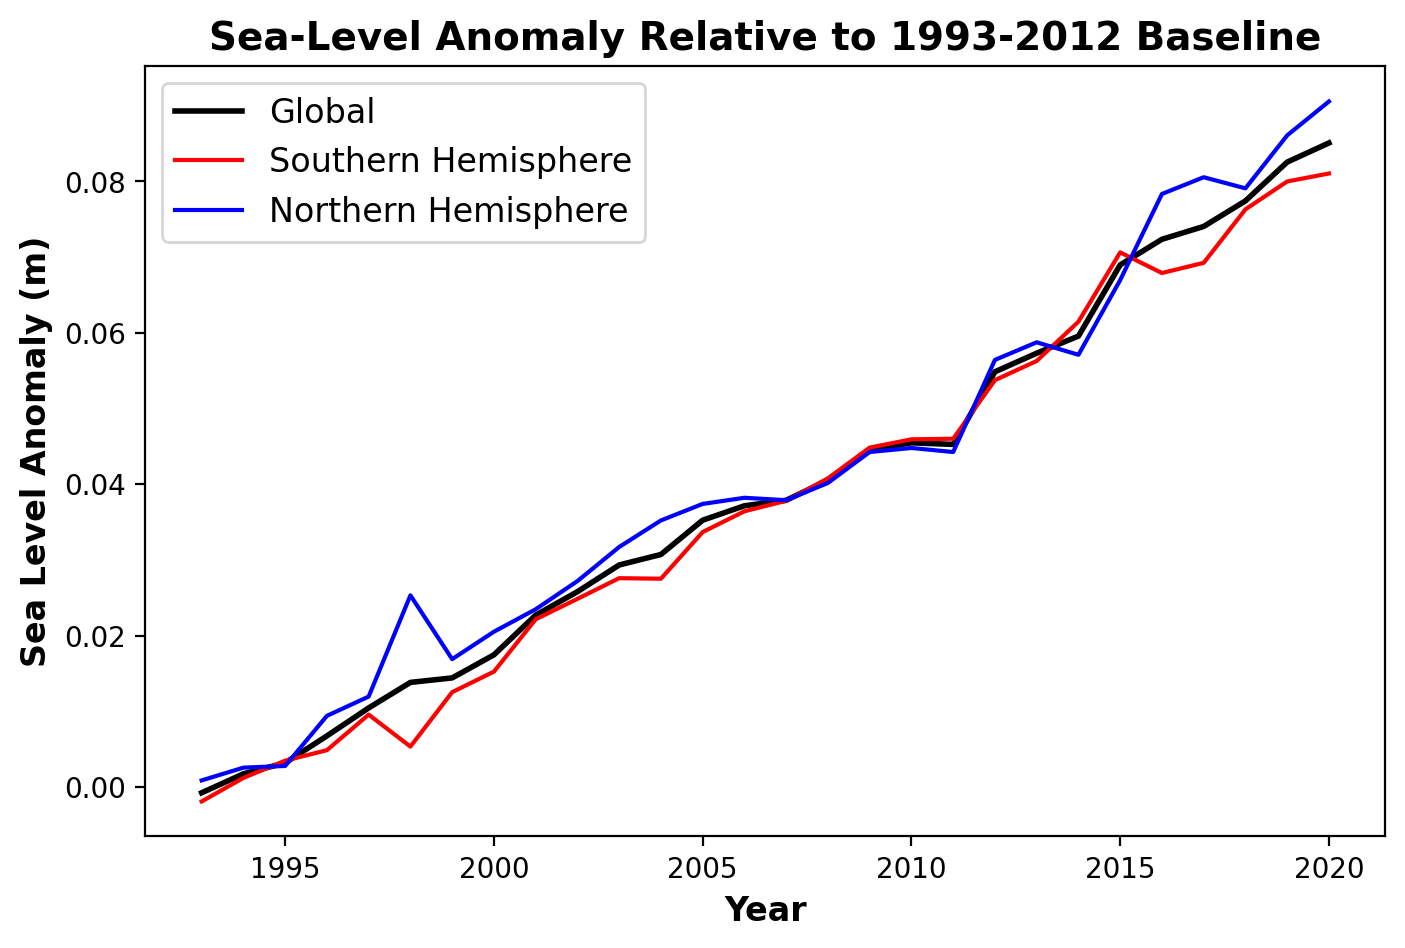

In [136]:
fig, ax = plt.subplots(figsize=(8,5))

ax.plot(sea_lev_ann.time_year, mean_sea_lev_global, color='k', lw=2, label='Global')
ax.plot(sea_lev_ann.time_year, mean_sea_lev_sh, color='red', label='Southern Hemisphere')
ax.plot(sea_lev_ann.time_year, mean_sea_lev_nh, color='blue', label='Northern Hemisphere')

ax.set_title('Sea-Level Anomaly Relative to 1993-2012 Baseline', fontsize=14, weight='bold')
ax.set_xlabel('Year', fontsize=12, weight='bold')
ax.set_ylabel(r'Sea Level Anomaly (m)', fontsize=12, weight='bold')

ax.tick_params(labelsize=10)

ax.legend(fontsize=12)

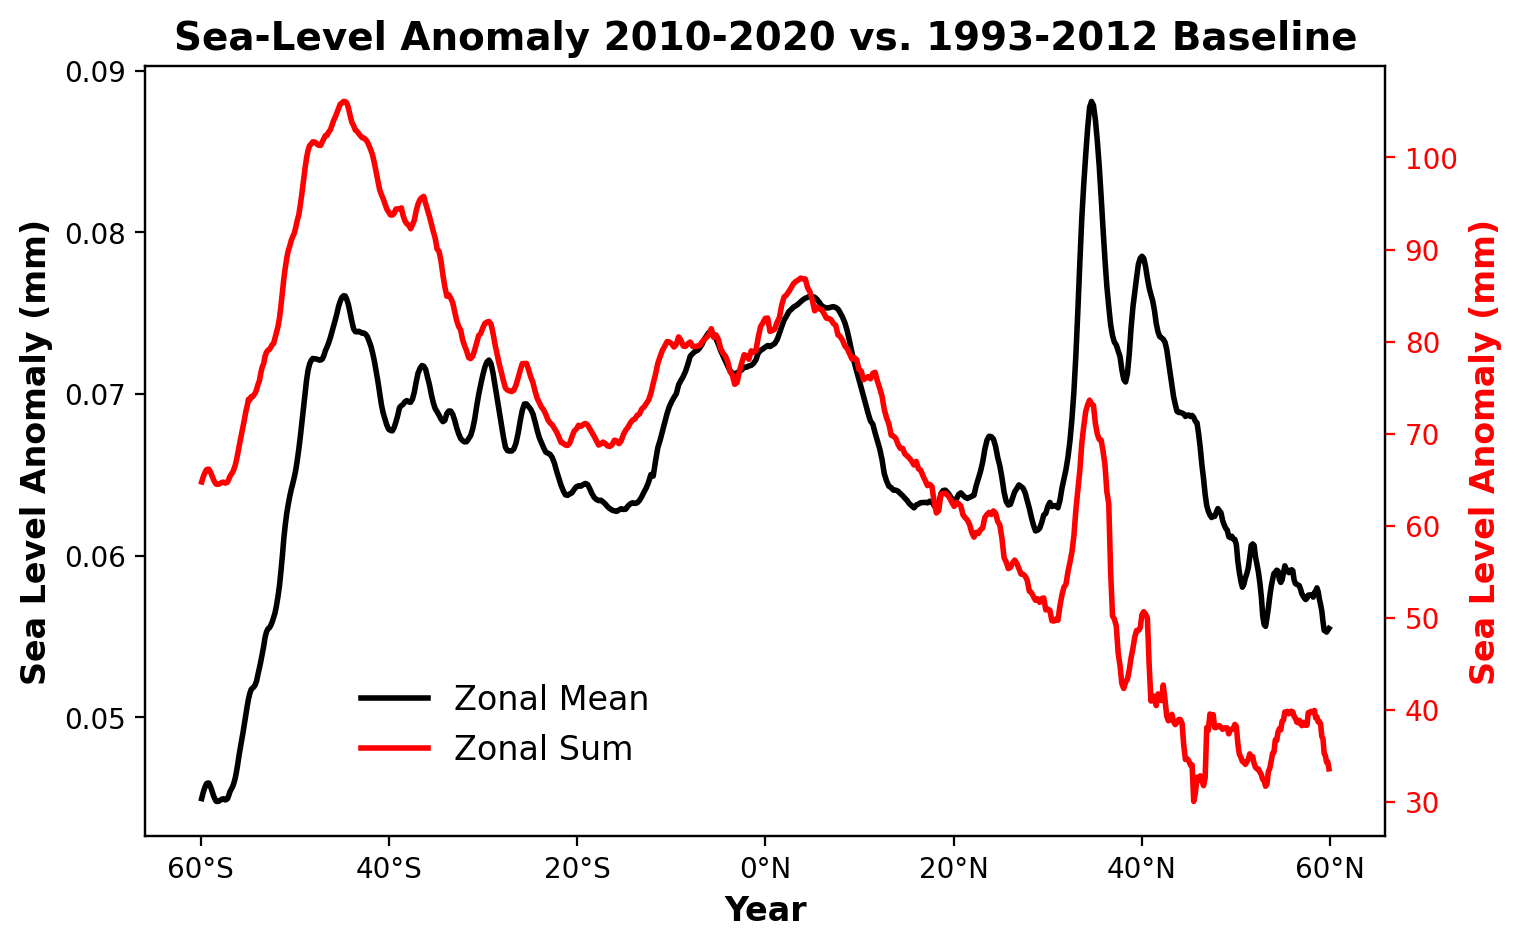

In [135]:
fig, ax = plt.subplots(figsize=(8,5))

sea_lev_zonal_mean_anom.plot(color='k', lw=2, label='Zonal Mean', ax=ax)

ax2 = ax.twinx()

sea_lev_mean_zonal_sum.plot(color='red', lw=2, label='Zonal Sum', ax=ax2)

ax2.tick_params(axis = 'y', labelcolor='red', color='red')

ax.set_title('Sea-Level Anomaly 2010-2020 vs. 1993-2012 Baseline', fontsize=14, weight='bold')
ax.set_xlabel('Year', fontsize=12, weight='bold')

ax.set_ylabel(r'Sea Level Anomaly (mm)', fontsize=12, weight='bold')
ax2.set_ylabel(r'Sea Level Anomaly (mm)', fontsize=12, color='red', weight='bold')

ax.xaxis.set_major_formatter(FuncFormatter(formatter_NStransect))
ax.tick_params(labelsize=10)
ax2.tick_params(labelsize=10)

fig.legend(loc='lower center', bbox_to_anchor = (.35, .15), fontsize=12, frameon=False)

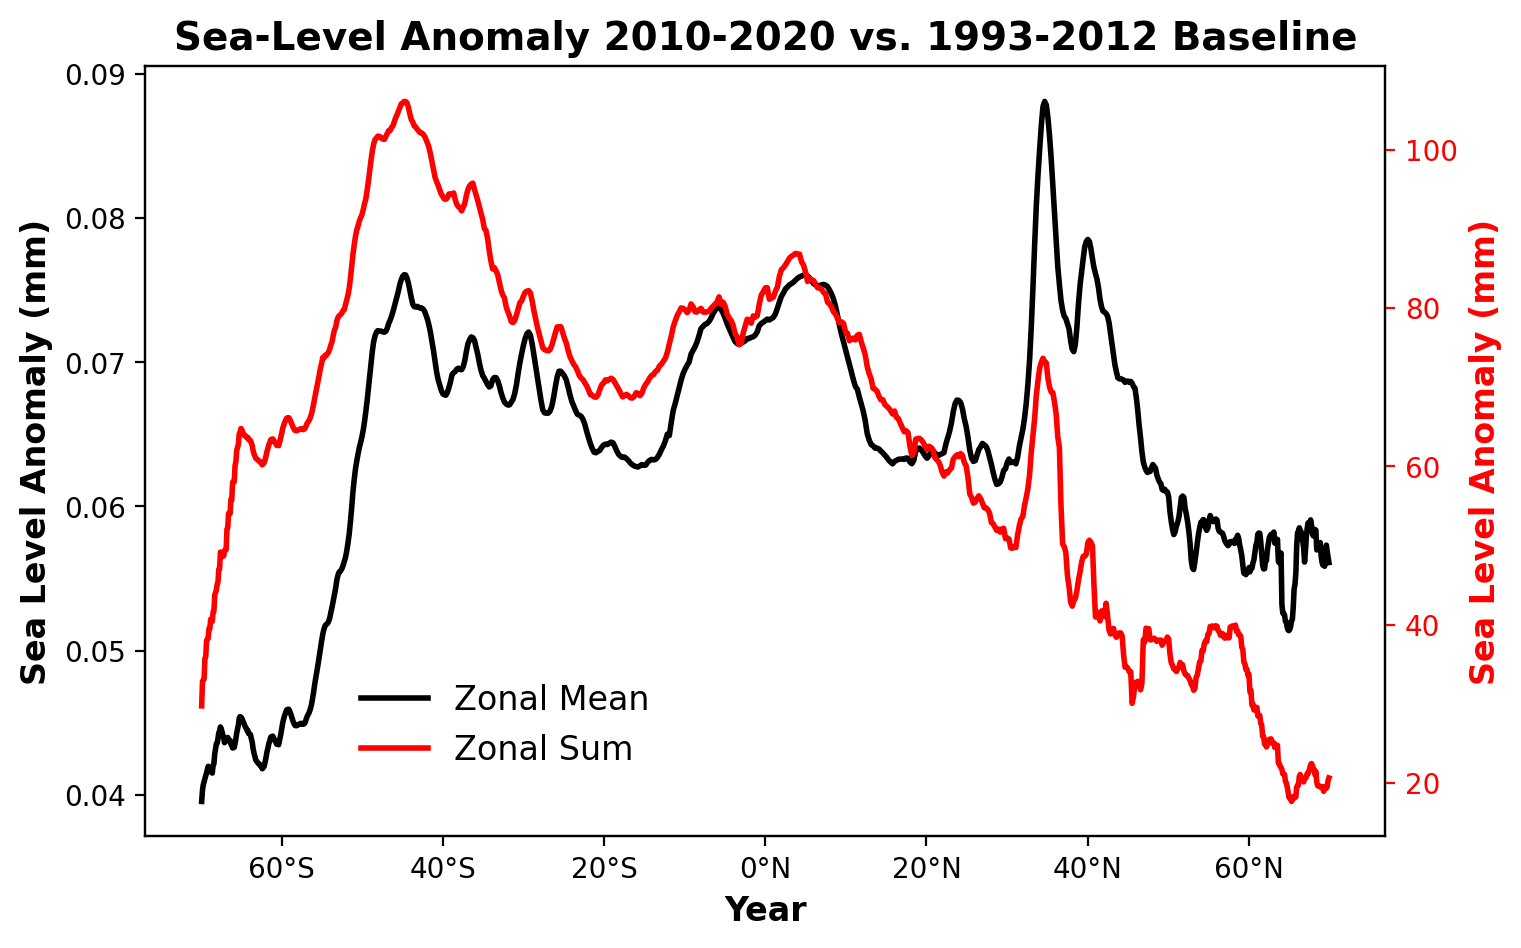

In [20]:
fig, ax = plt.subplots(figsize=(8,5))

sea_lev_zonal_mean_anom.plot(color='k', lw=2, label='Zonal Mean', ax=ax)

ax2 = ax.twinx()

sea_lev_mean_zonal_sum.plot(color='red', lw=2, label='Zonal Sum', ax=ax2)

ax2.tick_params(axis = 'y', labelcolor='red', color='red')

ax.set_title('Sea-Level Anomaly 2010-2020 vs. 1993-2012 Baseline', fontsize=14, weight='bold')
ax.set_xlabel('Year', fontsize=12, weight='bold')

ax.set_ylabel(r'Sea Level Anomaly (mm)', fontsize=12, weight='bold')
ax2.set_ylabel(r'Sea Level Anomaly (mm)', fontsize=12, color='red', weight='bold')

ax.xaxis.set_major_formatter(FuncFormatter(formatter_NStransect))
ax.tick_params(labelsize=10)
ax2.tick_params(labelsize=10)

fig.legend(loc='lower center', bbox_to_anchor = (.35, .15), fontsize=12, frameon=False)

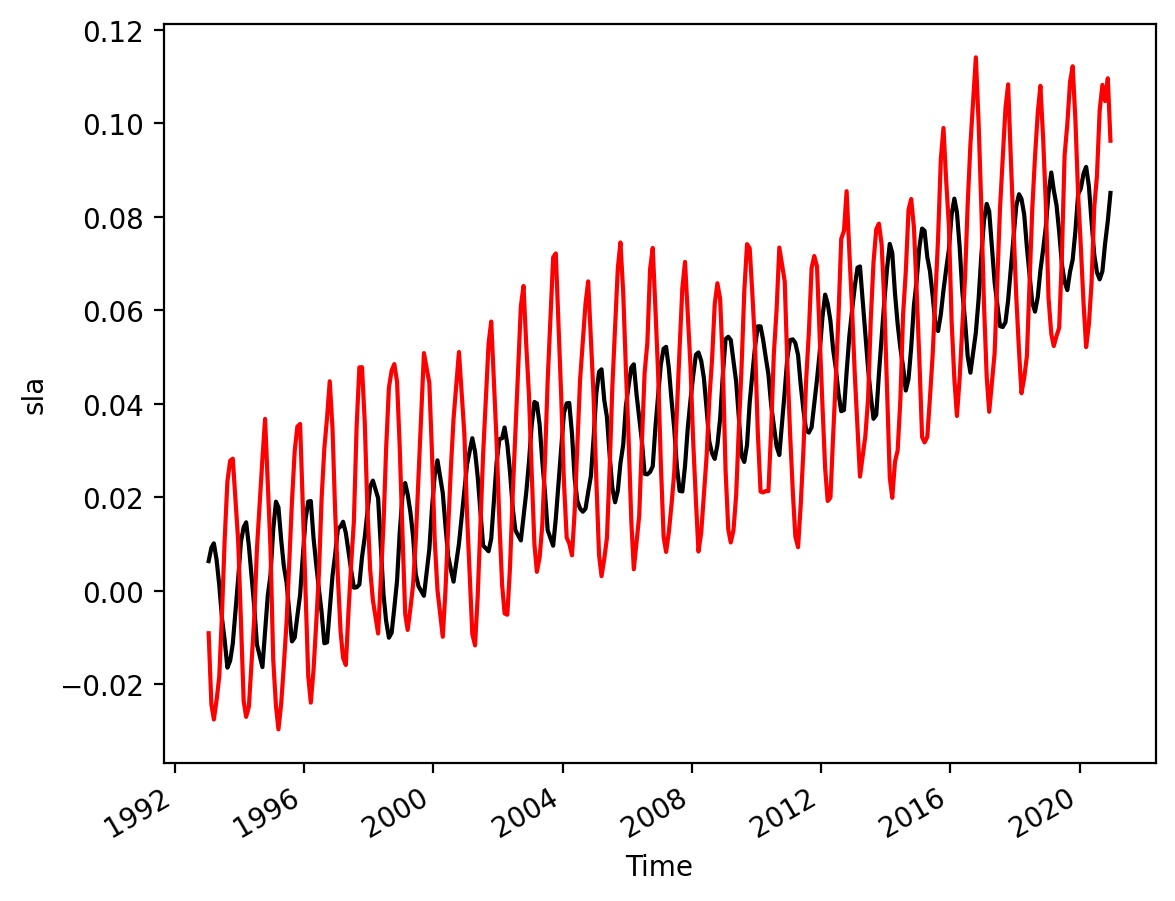

In [27]:
sh_sl = sea_lev.sla.sel(latitude=slice(-90,0)).mean(['latitude','longitude'])
nh_sl = sea_lev.sla.sel(latitude=slice(0,90)).mean(['latitude','longitude'])

sh_sl.plot(color='black')
nh_sl.plot(color='red')